In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
df_CASP = pd.read_csv ("/Users/paolovalentini/Downloads/yeast.data")

id_names = ['sequence_name']

features_names = ['mcg','gvh','alm','mit','erl','pox','vac','nuc']

class_names = ['class']

columns_names = id_names + features_names +class_names

df_YEAST = pd.read_csv("/Users/paolovalentini/Downloads/yeast.data",names = columns_names,sep='\s+')

In [3]:
df_YEAST

,sequence_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


## PROBLEMA DE CLASIFICACIÓN DE DATOS
Inicialmente, realicé un análisis exploratorio de los datos que me permitió comprender qué clases del dataset YEAST son dominantes y qué atributos son menos influyentes en él. Esto fue posible gracias al uso de histogramas y gráficos. 

In [4]:
def GetMetricas(df_):

    media = df_.mean()
    mediana = df_.median()
    desvio = df_.std()
    atributos = list(media.index)
    dicc = {'Atributos': atributos}
    metricas = pd.DataFrame(dicc)
    metricas["Media"] = np.array(media)
    metricas["Mediana"] = np.array(mediana)
    metricas["Desvio"] = np.array(desvio)
    
    return metricas

In [5]:
metricas_CASP = GetMetricas(df_CASP)
metricas_yeast = GetMetricas(df_YEAST)
print(metricas_yeast)

  Atributos     Media  Mediana    Desvio
0       mcg  0.500121     0.49  0.137299
1       gvh  0.499933     0.49  0.123924
2       alm  0.500034     0.51  0.086670
3       mit  0.261186     0.22  0.137098
4       erl  0.504717     0.50  0.048351
5       pox  0.007500     0.00  0.075683
6       vac  0.499885     0.51  0.057797
7       nuc  0.276199     0.22  0.106491


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/990671553.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  media = df_.mean()
/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/990671553.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mediana = df_.median()
/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/990671553.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  desvio = df_.std()
/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T

aquí podemos ver inmediatamente cuales de los atributos tienen una desviación estándar muy baja y, en consecuencia, la variación dentro del dataset es mínima. Esos son 'pox' y 'erl'.

In [6]:
class_vector = []
for it in df_YEAST['class']:
    if it not in class_vector:
        class_vector.append(it)

balance_class= {}
for it in class_vector:
    print(it+':',sum(df_YEAST['class'].values==it),'\tP(Y = '+it+')=', round(sum(df_YEAST['class'].values==it)/df_YEAST.shape[0],4))
    balance_class[it] = sum(df_YEAST['class'].values==it)/df_YEAST.shape[0]


MIT: 244 	P(Y = MIT)= 0.1644
NUC: 429 	P(Y = NUC)= 0.2891
CYT: 463 	P(Y = CYT)= 0.312
ME1: 44 	P(Y = ME1)= 0.0296
EXC: 35 	P(Y = EXC)= 0.0236
ME2: 51 	P(Y = ME2)= 0.0344
ME3: 163 	P(Y = ME3)= 0.1098
VAC: 30 	P(Y = VAC)= 0.0202
POX: 20 	P(Y = POX)= 0.0135
ERL: 5 	P(Y = ERL)= 0.0034


In [7]:
b_clases_yeast = df_YEAST['class'].value_counts()
print(b_clases_yeast)

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: class, dtype: int64


Hasta aquí anotamos cuáles son las clases más frecuentes y cuáles las menos, incluyendo la probabilidad de cada una.

In [8]:
frec = b_clases_yeast / len(df_YEAST)
print(frec)
print(frec[0]+frec[1]+frec[2]+frec[3])
print(frec[0]+frec[1])

CYT    0.311995
NUC    0.289084
MIT    0.164420
ME3    0.109838
ME2    0.034367
ME1    0.029650
EXC    0.023585
VAC    0.020216
POX    0.013477
ERL    0.003369
Name: class, dtype: float64
0.8753369272237197
0.601078167115903


Ya se puede ver que las dos clases más frecuentes (CYT, NUC) cubren el 60% de los casos y las cuatro más frecuentes (CYT, NUC, MIT, ME3) el 87%.

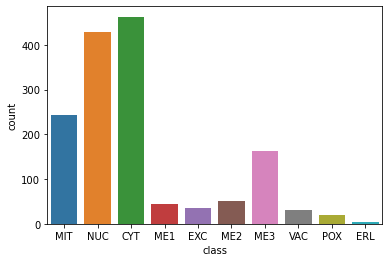

In [9]:
x = df_YEAST['class']
ax = sns.countplot(x=x, data = df_YEAST)

# Histrogramas de distribución de atributos.

#### Class Independent

/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/3213550776.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_YEAST.drop(columns = ["class","sequence_name"]).hist(ax=ax)


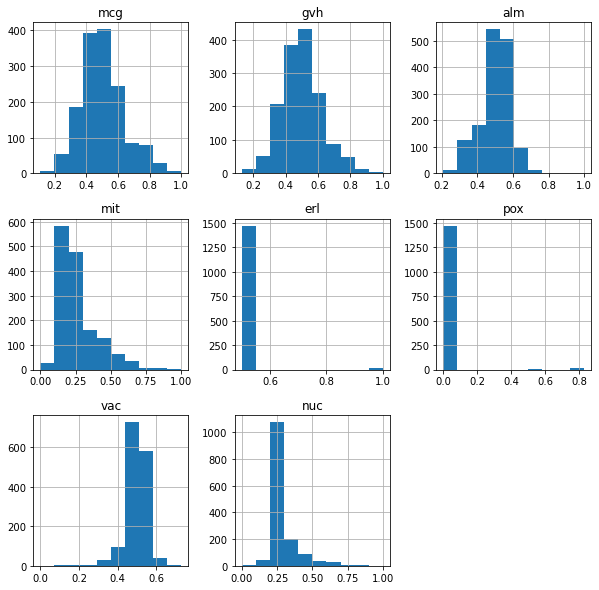

In [10]:
clases = set(df_YEAST["class"])

fig, ax =plt.subplots(figsize=(10,10))
df_YEAST.drop(columns = ["class","sequence_name"]).hist(ax=ax)
plt.show()

#### Class Dependent

ME2


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


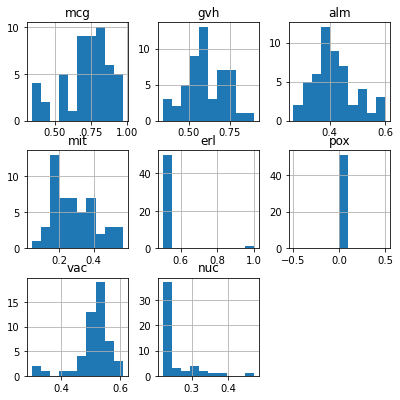

ERL


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


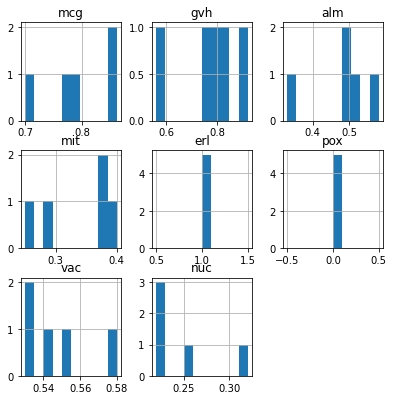

POX


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


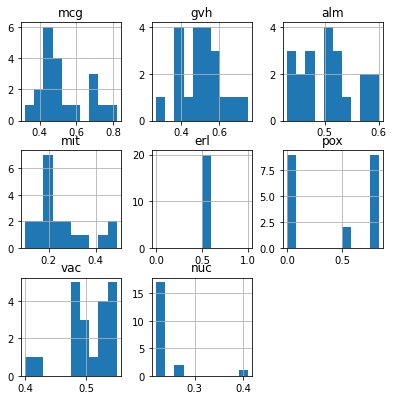

MIT


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


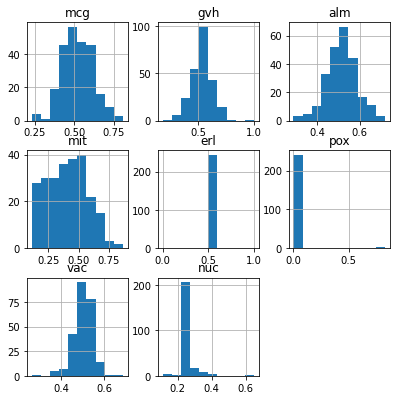

CYT


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


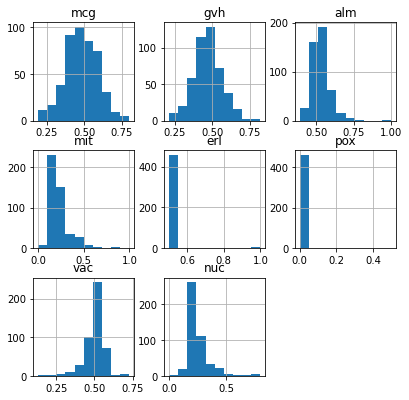

ME1


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


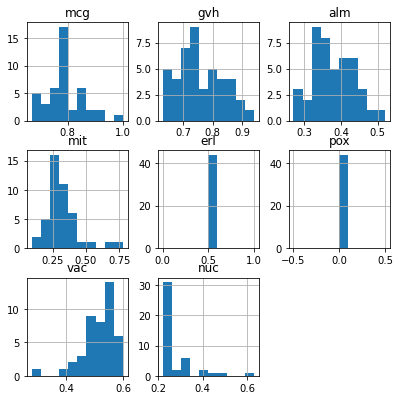

ME3


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


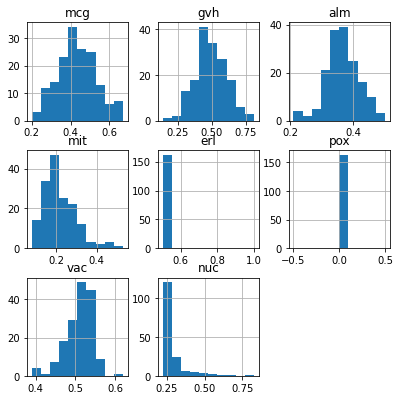

VAC


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


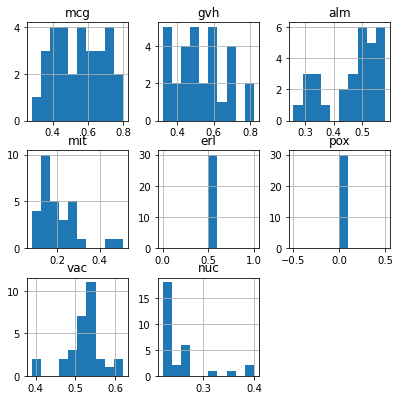

NUC


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


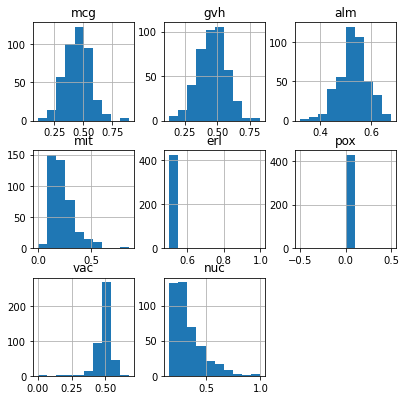

EXC


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/576728008.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


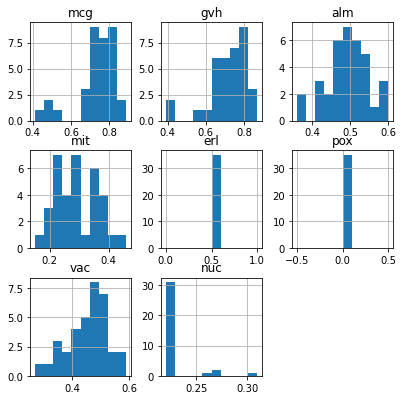

In [11]:
for clase in clases:
   
    df_clase = df_YEAST.loc[df_YEAST["class"] == clase]
    df_clase = df_clase.drop(["class","sequence_name"], axis =1)
    atributos = df_clase.columns.values
    print(clase)
    
    fig, ax =plt.subplots(figsize=(6.5,6.5))
    df_clase.hist(ax=ax)
    plt.show()

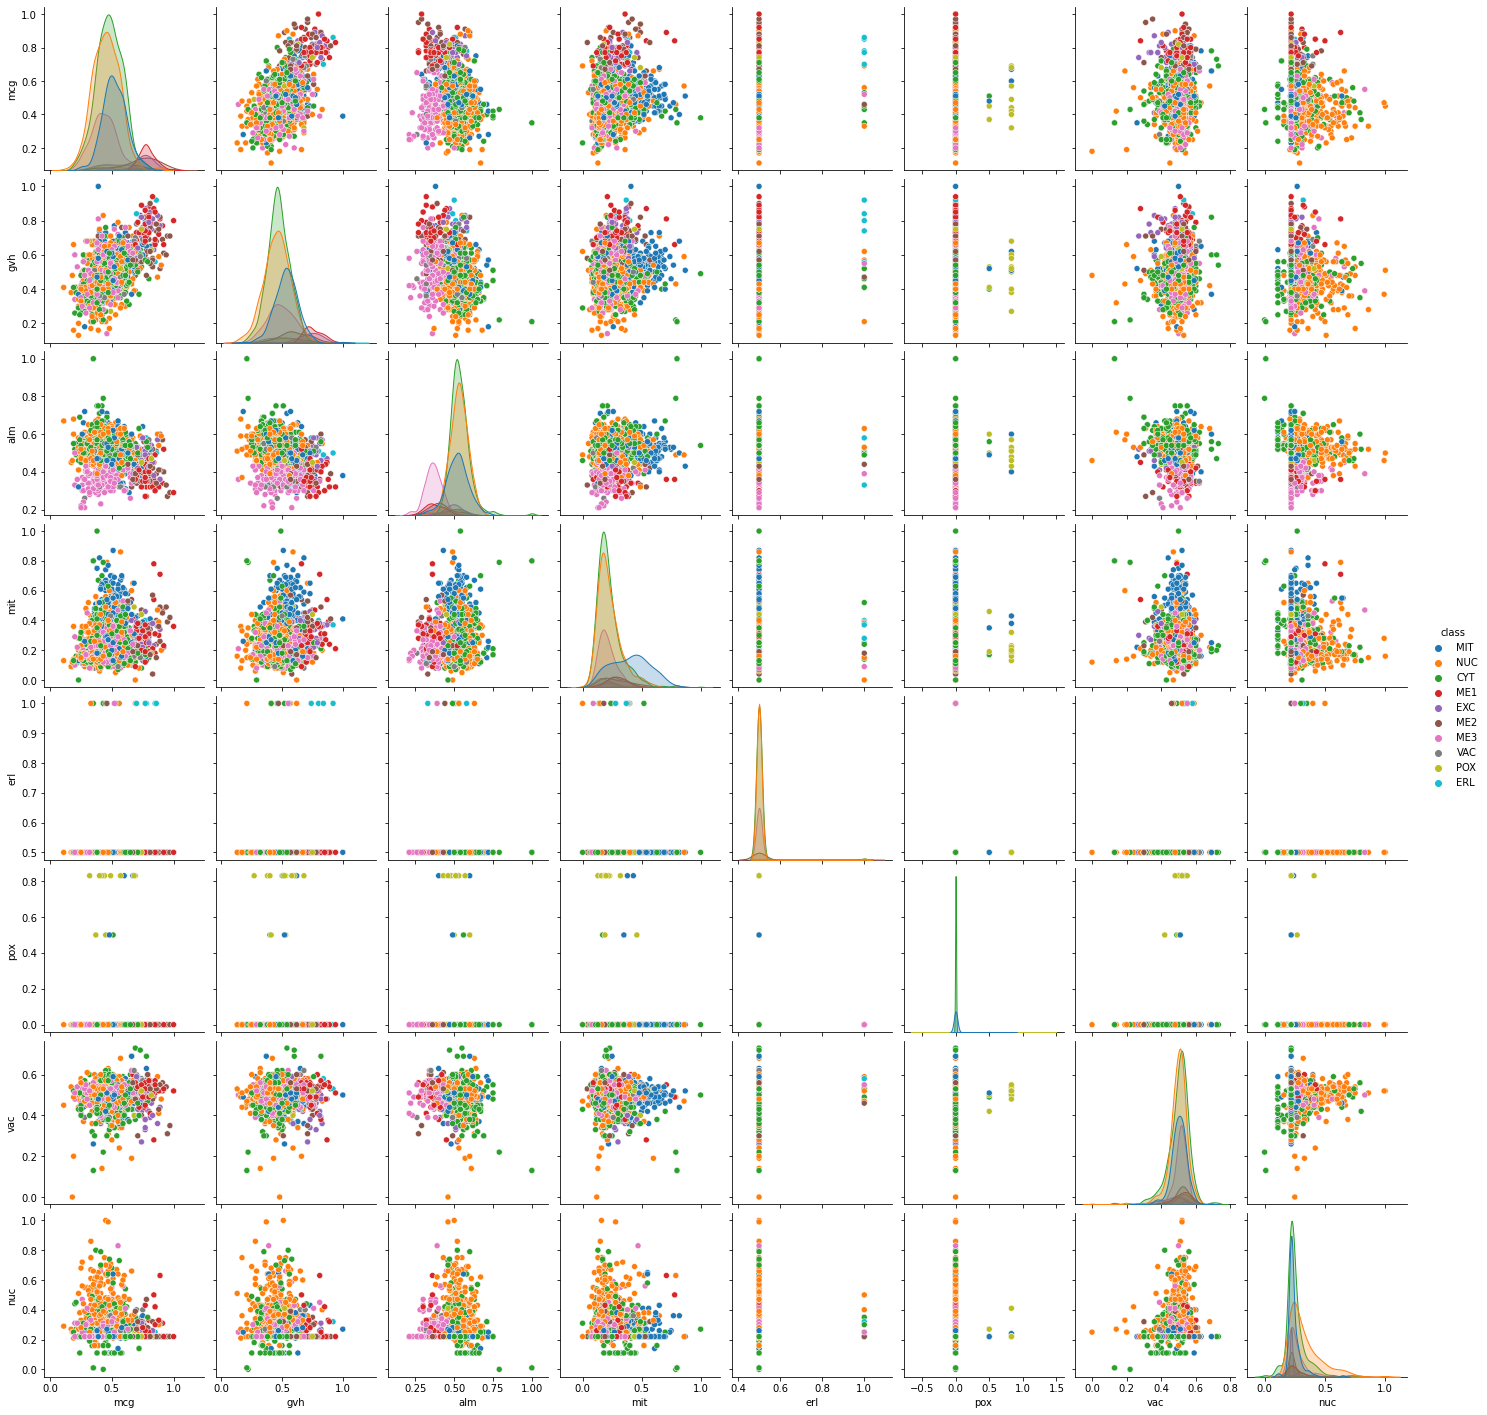

In [12]:
sns.pairplot(df_YEAST, hue = 'class')


In [13]:
df_YEAST = df_YEAST.drop(['pox','erl'], axis=1)
features_names.remove("erl")
features_names.remove("pox")

## Consideraciones, selección de atributos y clases para optimizar la clasificación

Lo que se desprende del análisis de los datos es que hay cuatro clases predominantes: CYT, NUC, MIT, ME3, de las cuales CYT y NUC ocupan el 60%. Por esta razón, se decidió utilizar sólo las cuatro clases para la clasificación multiclase. 

Para la clasificación binaria, se decidió utilizar sólo las dos clases predominantes porque daban una buena estimación de la tendencia del conjunto de datos. 

El análisis exploratorio de los datos también reveló que los dos atributos "pox" y "erl" tenían una desviación estándar muy insignificante y, en consecuencia, se decidió eliminarlos de los atributos debido a su insignificancia.

Para la estrategia de agrupación, se analizó la distribución de los atributos divididos en clases. Se analizaron histogramas y gráficos de dispersión de los atributos divididos en clases. En muchos casos, la distribución de los atributos parece similar, siendo los más parecidos CYT y MIT; CYT y NUC son el 60% del total, por lo que decidimos agruparlos en un lado y las otras seis clases (que ocupan el 40% de los casos) en el otro para equilibrar las clases. 

In [14]:
df_YEAST

,sequence_name,mcg,gvh,alm,mit,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.53,0.39,NUC


Se decidió utilizar QDA,LDA y Regresión Logística para la clasificación. Para evaluar la calidad del clasificador, comenzamos utilizando sólo un atributo hasta 6, y seleccionando el mejor mediante la función 'SelectKBest' de sklearn. 



In [15]:
def clasificador(clf, metricas, clf_X, clf_Y, intervalos = 5, poly = False):
    puntuaciones_test = pd.DataFrame(columns=metricas)
    mejores_atributos = []
    atributos = list(clf_X.keys())
    atrib = []
    numero = np.arange(1,len(atributos)+1)
    largo = len(atributos)
    cv = KFold(n_splits=intervalos, random_state=10, shuffle=True)
    train_score = False 
    
    if poly != False:
        puntuaciones_train = pd.DataFrame(columns=metricas)
        clf_X_mejores = poly.fit_transform(clf_X[atributos].values)
        largo = 1
        train_score = True

        
    for i in range(largo):
        if poly == False:
            aux = SelectKBest(k=i+1).fit_transform(clf_X, clf_Y)
            atrib_actuales = []
            clf_X_mejores = pd.DataFrame(aux, columns = numero[:i+1])
            
            for j in range(len(aux[0])):
                
                for atributo in atributos:
                    if len(aux[0])==1:
                
                        a = np.array(clf_X_mejores[j+1])

                    else:
                        a = np.array(clf_X_mejores[j+1])

                    b = np.array(clf_X[atributo])

                    equal_arrays = ( a == b).all()

                    if equal_arrays:
                        atrib_actuales.append(atributo)
            atrib.append(atrib_actuales)
        
        
        
        val_cruz_scores = (cross_validate(clf, clf_X_mejores, clf_Y, scoring=metricas, cv = cv, return_train_score =  train_score))
        scores_test = []

        for metrica in metricas:
           scores_test.append(val_cruz_scores["test_" + metrica].mean())
        
        puntuaciones_test.loc[len(puntuaciones_test)] = scores_test
        
    if poly == False:
        return puntuaciones_test, atrib
    else: 
        scores_train = []

        for metrica in metricas:
            
           scores_train.append(val_cruz_scores["train_" + metrica].mean())
        
        puntuaciones_train.loc[len(puntuaciones_train)] = scores_train

        return puntuaciones_test, puntuaciones_train

In [16]:
def maximos_scores(metricas, atributos, df):

    maximos = {}
   
    for metrica in metricas: 

        columna = np.array(df[metrica])
        index = columna.argmax()
        maximo = columna.max()

        maximos[metrica] = [maximo,atributos[index]]
    
    for metrica in metricas:
        print("El " + metrica + " maximo es: ", maximos[metrica][0], ", atributos usados: ",maximos[metrica][1])

    return maximos
        

#### Clasificación multiclase

In [17]:
df_YEAST_mult = df_YEAST[df_YEAST['class'].isin(["NUC","CYT","MIT","ME3"])]

df_atributos = df_YEAST_mult.drop(["class","sequence_name"], axis=1)
df_clases = df_YEAST_mult.drop(['mcg','gvh','alm','mit','vac','nuc'], axis=1)
df_clases = df_clases.drop("sequence_name", axis=1)

atributos = list(df_atributos.keys())

enc = LabelEncoder()
df_clases = enc.fit_transform(df_clases)
clases = np.unique(df_clases)


/Users/paolovalentini/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
metricas = ["f1_micro","f1_macro"]
clf_QDA = QuadraticDiscriminantAnalysis()
clf_LDA = LinearDiscriminantAnalysis()
clf_logit = LogisticRegression()
df_QDA, atrib_QDA = clasificador(clf_QDA, metricas, df_atributos, df_clases, 6)
df_LDA, atrib_LDA= clasificador(clf_LDA, metricas, df_atributos, df_clases, 6)
df_logit, atrib_logit= clasificador(clf_logit, metricas, df_atributos, df_clases, 6)

print("QDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_QDA))
print("LDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_LDA))
print("Logit")
maximos=(maximos_scores(metricas, atrib_QDA, df_logit))

QDA:
El f1_micro maximo es:  0.6127823291801787 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.642434492841963 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
LDA:
El f1_micro maximo es:  0.6212557603686636 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.6519533664334859 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
Logit
El f1_micro maximo es:  0.6120249473744098 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.6385841310273486 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']


#### Clasificación binaria

In [19]:
df_YEAST_bin = df_YEAST[df_YEAST['class'].isin(["NUC","CYT"])]
df_atributos_bin = df_YEAST_bin.drop(["class","sequence_name"], axis=1)
df_clases_bin = df_YEAST_bin.drop(['mcg','gvh','alm','mit','vac','nuc'], axis=1)
df_clases_bin = df_clases_bin.drop("sequence_name", axis=1)
atributos = list(df_atributos.keys())
enc = LabelEncoder()
df_clases_bin = enc.fit_transform(df_clases_bin)
clases_bin = np.unique(df_clases_bin)

/Users/paolovalentini/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
max_iter = 5000
metricas = ["roc_auc"]
clf_QDA = QuadraticDiscriminantAnalysis()
clf_LDA = LinearDiscriminantAnalysis()
clf_logit = LogisticRegression(C = 1e10, max_iter = max_iter)
df_QDA,atrib_QDA = clasificador(clf_QDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_LDA,atrib_QDA = clasificador(clf_LDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_logit, atrib_logit= clasificador(clf_logit, metricas, df_atributos_bin, df_clases_bin, 5)

print("QDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_QDA))
print("LDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_LDA))
print("Logit")
maximos=(maximos_scores(metricas, atrib_QDA, df_logit))

QDA:
El roc_auc maximo es:  0.6846553258877031 , atributos usados:  ['mcg', 'gvh', 'alm', 'mit', 'vac', 'nuc']
LDA:
El roc_auc maximo es:  0.7030338636792623 , atributos usados:  ['mcg', 'gvh', 'alm', 'vac', 'nuc']
Logit
El roc_auc maximo es:  0.7049763662780733 , atributos usados:  ['mcg', 'gvh', 'alm', 'vac', 'nuc']


## PROBLEMA DE REGRESIÓN

#### Análisis y clasificación de datos

In [21]:
df = pd.read_csv("/Users/paolovalentini/Downloads/CASP.csv")

df

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147
...,...,...,...,...,...,...,...,...,...,...
45725,3.762,8037.12,2777.68,0.34560,64.3390,1.105797e+06,112.7460,3384.21,84,36.8036
45726,6.521,7978.76,2508.57,0.31440,75.8654,1.116725e+06,102.2770,3974.52,54,36.0470
45727,10.356,7726.65,2489.58,0.32220,70.9903,1.076560e+06,103.6780,3290.46,46,37.4718
45728,9.791,8878.93,3055.78,0.34416,94.0314,1.242266e+06,115.1950,3421.79,41,35.6045


In [22]:
df.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


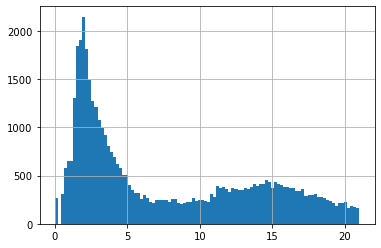

In [23]:
Distribución_RMSD = df['RMSD'].hist(bins = 100)

In [24]:
df_X = df.drop('RMSD', axis=1)

df_X

,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147
...,...,...,...,...,...,...,...,...,...
45725,8037.12,2777.68,0.34560,64.3390,1.105797e+06,112.7460,3384.21,84,36.8036
45726,7978.76,2508.57,0.31440,75.8654,1.116725e+06,102.2770,3974.52,54,36.0470
45727,7726.65,2489.58,0.32220,70.9903,1.076560e+06,103.6780,3290.46,46,37.4718
45728,8878.93,3055.78,0.34416,94.0314,1.242266e+06,115.1950,3421.79,41,35.6045


/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/3359738163.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_X.hist(ax = ax, bins = 100)


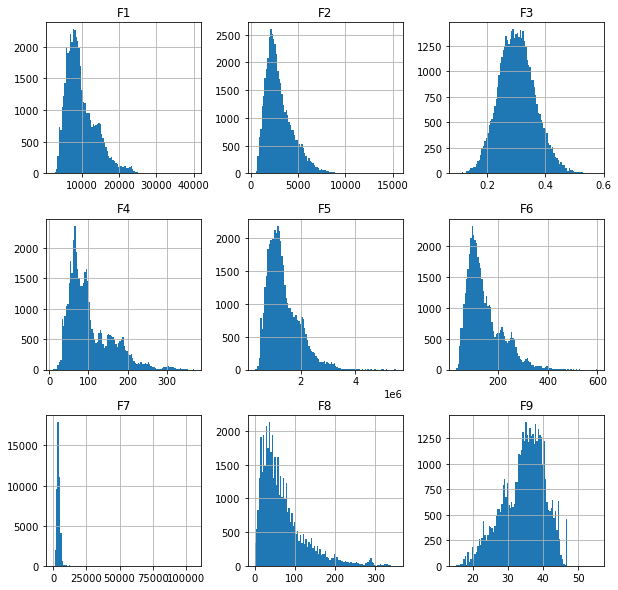

In [25]:
fig, ax =plt.subplots(figsize=(10,10))
df_X.hist(ax = ax, bins = 100)
plt.show()

Se puede ver que F7 es una variable discreta que tiene la mayoría de los valores agregados y algunos valores distantes. Por lo tanto, es mejor normalizar los datos para no tener un desequilibrio. 

/var/folders/4x/xqpfkttj3sl7nfzt1typb50w0000gn/T/ipykernel_63498/126940855.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_X_norm.hist(ax = ax, bins = 100)


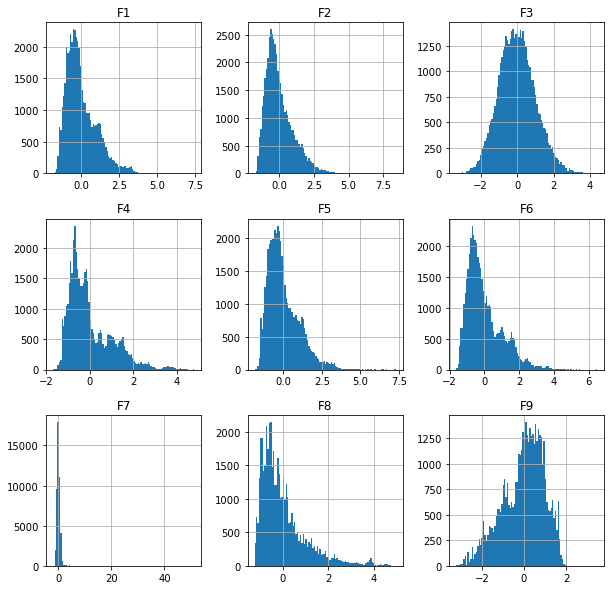

In [26]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_X)
scaled = scaler.fit_transform(df_X)

df_X_norm = pd.DataFrame(scaled, columns = df_X.keys())
fig, ax =plt.subplots(figsize=(10,10))
df_X_norm.hist(ax = ax, bins = 100)
plt.show()

## Regresión

Para la regresión, el ajuste de los ingresos se hizo con el orden 2,3,4 para ver cuál era el más preciso para devolver los valores exactos,osea el menor MSE.

#### Sin features polinomiales

In [27]:
metricas = ["neg_mean_squared_error","r2"]
clf_linear = LinearRegression()
df_regresión = df["RMSD"]
df_linear, atrib_linear = clasificador(clf_linear, metricas, df_X_norm,df_regresión , 5)

maximos=(maximos_scores(metricas, atrib_linear, df_linear))

El neg_mean_squared_error maximo es:  -26.879525467294247 , atributos usados:  ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
El r2 maximo es:  0.2818864396737455 , atributos usados:  ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']


#### Features polinomiales

In [28]:
poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)
poly4 = PolynomialFeatures(4)
poly5 = PolynomialFeatures(5)
clf_linear = LinearRegression()
df_linear_poly_test_2, df_linear_poly_train_2 = clasificador(clf_linear, metricas, df_X_norm, df_regresión, 5, poly = poly2)

df_linear_poly_test_3, df_linear_poly_train_3 = clasificador(clf_linear, metricas, df_X_norm, df_regresión, 5, poly = poly3)

df_linear_poly_test_4, df_linear_poly_train_4 = clasificador(clf_linear, metricas, df_X_norm, df_regresión, 5, poly = poly4)

df_linear_poly_test_5, df_linear_poly_train_5 = clasificador(clf_linear, metricas, df_X_norm, df_regresión, 5, poly = poly5)

In [29]:
print("Test Scores: 2nd order")
print(df_linear_poly_test_2)
print("Train Scores: 2nd order")
print(df_linear_poly_train_2)

print("Test Scores: 3rd order")
print(df_linear_poly_test_3)
print("Train Scores: 3rd order")
print(df_linear_poly_train_3)

print("Test Scores: 4th order")
print(df_linear_poly_test_4)
print("Train Scores: 4th order")
print(df_linear_poly_train_4)

print("Test Scores: 5th order")
print(df_linear_poly_test_5)
print("Train Scores: 5th order")
print(df_linear_poly_train_5)

Test Scores: 2nd order
   neg_mean_squared_error        r2
0              -23.774358  0.364851
Train Scores: 2nd order
   neg_mean_squared_error       r2
0              -23.662403  0.36787
Test Scores: 3rd order
   neg_mean_squared_error       r2
0              -29.782743  0.20618
Train Scores: 3rd order
   neg_mean_squared_error        r2
0              -21.181641  0.434143
Test Scores: 4th order
   neg_mean_squared_error         r2
0             -3425.29645 -90.546726
Train Scores: 4th order
   neg_mean_squared_error        r2
0              -19.120945  0.489194
Test Scores: 5th order
   neg_mean_squared_error           r2
0           -2.682354e+07 -714143.6488
Train Scores: 5th order
   neg_mean_squared_error        r2
0              -16.385842  0.562262


El análisis de los datos muestra que a partir del orden 3 se produce un fuerte overfitting, es decir, el modelo deja muy poco margen para los puntos que no entran en ese range. 

#### Features polinómiales + conjunto de validación

In [30]:
atributos = list(df_X_norm.keys())

for i in range(2,6):
    poly =  PolynomialFeatures(i)
    df_X_norm_mejores = poly.fit_transform(df_X_norm[atributos].values)
    X_train, X_rem, y_train, y_rem = train_test_split(df_X_norm_mejores, df_regresión, test_size= 0.8, random_state= 26)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=False)
    clf_linear = LinearRegression()
    clf_linear.fit(X_train,y_train)
    prediccion = clf_linear.predict(X_valid)
    print("2nd order polinomial features ",i)

    print("Mean squared error: %.2f" % metrics.mean_squared_error(y_valid, prediccion))

    print("r^2: %.2f" % metrics.r2_score(y_valid, prediccion))


2nd order polinomial features  2
Mean squared error: 32.69
r^2: 0.13
2nd order polinomial features  3
Mean squared error: 465.60
r^2: -11.42
2nd order polinomial features  4
Mean squared error: 2568563.54
r^2: -68526.08
2nd order polinomial features  5
Mean squared error: 78079999227.14
r^2: -2083107642.55


En este caso, la precisión del modelo es menor porque el 10% del dataset se dejó para el texteo y el 10% para la validación. El 80% de los datos se utiliza para el entrenamiento.